#### imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
import transforms3d as t3d
import matplotlib
import os

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8sdb7x5h because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Introduction

P_x, P_y, P_z: Positions of the center of the markers on the forque based on the global coordinate.

O_x, O_y, O_z: Euler angles of the forque. The initial orientation of the forque is when the orientation of the local marker coordinate system (x_m, y_m, z_m) aligns with the orientation of the global coordinate system (X, Y, Z). 

# Inputs/Constants

In [2]:
foodname = "carrot"
foldername = f"fork_trajectory_{foodname}"
tip_rel_pose = [0,0,0.274]
down_hysterisis = 0.02
up_hysterisis = 0.02
max_height_after_plate = 0.04
max_height_above_contact = 0.01
trajectory_segment_must_go_this_low = 0.1

# Functions

##  Function to transform recordings to standard global coord frame 

In [3]:
# input: 
#      row of tapo dataset
# return:
#       x,y,z tip position
#       and w,x,y,z quaternion tip rotation.
# Note: if you convert the quaternion to a rotMat using t3d.quaternions.quat2mat(quat)
#       then that matrix transform orientation vectors in the STANDARD fork coordinate frame
#       to write them in the global coordinate frame 
#       (rotMat @ vector_fork_frame) = vector_global_frame
def getTipPosQuat(dpt, tip_rel_pose):
    # the position of the mocap marker origin (near base of fork)
    base_pos = np.array((dpt["P_xm"],dpt["P_ym"],dpt["P_zm"]))
    # compute the fork rotation quaternion
    quat = t3d.euler.euler2quat(dpt["O_zrad"], dpt["O_yrad"], dpt["O_xrad"], 'rzyx')
    
    # It's not entirely clear why the next line is necessary (perhaps the axes are mislabeled in the image?)
    # By default, the quat given has (when the fork is in the mouth):
    #     X points down to ground
    #     Y points back along fork out of mouth
    #     Z horizontally to the fork's left (eater's right)
    # The axes labeled in the image above have (when the fork is in the mouth):
    #     X points up
    #     Y horizontally to the fork's left (eater's right)
    #     Z back along fork out of mouth
    # so, to convert those, we would send x -> -x and send y->z and z->y, via the quaternion
    #tapo_quat = t3d.quaternions.qmult(quat,[0,0,np.sqrt(1/2),np.sqrt(1/2)])
    # HOWEVER, a better option would be to instead send to "standard" coordinates
    # When a spoon is held in the mouth, standard coordinates place:
    #     X horizontally to the fork's left (eater's right)
    #     Y up toward the ceiling
    #     Z along the prongs into the mouth
    # that is, we want to send new X -> Z, new Y -> -X, new Z -> -Y
    # so, we rotate around (x,-y,z) 1/3 of a turn.
    base_quat = t3d.quaternions.qmult(quat,[1/2,1/2,-1/2,1/2])
    
    # compute the rotation matrix to transform _from_ fork frame coordinates _to_ global frame coordinates
    # (eg: multiplying rotmat times (0,0,1) gives the fork's z direction in global coordinates)
    rotMat = t3d.quaternions.quat2mat(base_quat)
    

    # the tip is 0.3 in the fork's x direction
    tip_pos = base_pos + rotMat @ tip_rel_pose
    
    # The Global frame given in the paper has 
    # X pointing to eater's left
    # Y up
    # Z pointing away from user's mouth.
    # A Global frame that makes more sense for a robot base would have
    # X Forward/Away from Robot Base (pointing to the eater's left) (forward/away from human fork manipulator)
    # Y Left from Robot Base (pointing into the user's mouth) (left of human fork manipulator)
    # Z up
    # thus, to transform new axes to old axes we want to apply a rotation that sends 
    # new X -> stays dir of new X, new Y->dir pointed to by new Z, new Z -> dir pointed to by new -Y
    # That is, we want a negative quarter turn around the (x,0,0)
    global_tform_quat = [np.sqrt(1/2), np.sqrt(1/2),0,0]
    globalTformRotMat = t3d.quaternions.quat2mat(global_tform_quat)
    tip_pos = globalTformRotMat @ tip_pos
    base_quat = t3d.quaternions.qmult(global_tform_quat, base_quat)

    return tip_pos, base_quat

## Function to split apart a trajectory into "upward" and "downward" segments

In [4]:
# function to split apart attempts to pick up banana slice
# Inputs: clean_data (list of trajectories)
#         up_hysterisis:      how far fork needs to go up to count as having finished a "down"
#         down_hysterisis:    how far fork needs to go down to count as having finished an "up"
#         has_picked_up_fork: whether fork has already gone above 0.05 m (if false, ignore motion until above 0.05m)
#         debug:              whether to plot trajectories and segmentations
# Outputs: labeled_segments (list of trajectories segments (clips from original full trajectores
#                            including filename and attempt_array showing which part is down and which part up)
def segment_trajectory(clean_data, up_hysterisis, down_hysterisis, has_picked_up_fork=False, debug=False):
    labeled_segments = []
    for d in clean_data:
        local_min_max = 0
        current_attempt = 0
        is_rising = True
        attempt_array = []
        for h in d["tip_pos_array"][:,2]:
            # if we've gone over 0.05m, then next time near table counts as a real stab
            if h > 0.05:
                has_picked_up_fork = True
            # if rising, update local min/max hysteresis whenever we go up above prev extremum
            if is_rising and h > local_min_max:
                local_min_max = h
            # if was rising but now has fallen below hysteresis cutoff 
            # (AND below 0.09 m AND not ignoring the pickup noise before fork fully picked up)
            # switch to falling state (and add 0.5 to which attempt we're on)
            elif is_rising and h < min(local_min_max - down_hysterisis,0.09) and has_picked_up_fork:
                is_rising = False
                current_attempt += 0.5
            # if falling, update local min/max hysteresis whenever we go up below prev extremum
            elif not is_rising and h < local_min_max:
                local_min_max = h
            elif not is_rising and h > local_min_max + up_hysterisis:
                is_rising = True
                current_attempt += 0.5
            attempt_array.append(current_attempt)
        attempt_array = np.array(attempt_array)
        
        # for each down/up pair trajectory (that's why we added 0.5 each switch up/down and vice versa
        # so that now the final number is the number of pairs)
        for i in range(int(np.floor(attempt_array[-1]))):
            # when the trajectory was in the "going down" state for this attempt segment
            downward_inx = np.nonzero(attempt_array == i + 0.5)
            # the first index for the "going down" state for this attempt segment is the start
            start_inx = downward_inx[0][0]
            # the minimum height of the trajectory
            min_height = np.min(d["tip_pos_array"][downward_inx,2])
            # the last index for the "going down" state for this attempt segment
            # (remember, the "going down" state allows for some hysteresis, so this is
            # not the minimum height)
            inx = downward_inx[0][-1]
            # we use the last index for the "going down" state as our starting point
            # to search for the end of the trajectory.
            latest_height = d["tip_pos_array"][inx,2]
            # move forward in the trajectory until you start going down
            while (inx < len(d["tip_pos_array"]) and
                   not (d["tip_pos_array"][inx,2] < latest_height)):
                latest_height = d["tip_pos_array"][inx,2]
                inx += 1
            end_inx = inx
            labeled_segments.append({"tip_pos_array": d["tip_pos_array"],
                                     "quat_array": d["quat_array"],
                                     "attempt_array": attempt_array - 0.5, #saving attempt_array just for debugging. never used again
                                     "filename": d["filename"],
                                     "start_index": start_inx,
                                     "end_index": end_inx,
                                     "raw": d["raw"]})
    return labeled_segments

## Function to fit linear model and get t-value of predictions on new datapoint

In [5]:
# Fit a (constant) linear model on xvals, yvals, and then apply to x0 and compute tvalue of y0
# assuming gaussian residuals
def get_t_value_of_linear_model(xvals, yvals, x0, y0, constant_model = False):
    if constant_model:
        x = np.vstack([np.ones(len(xvals))]).T
    else:
        x = np.vstack([xvals, np.ones(len(xvals))]).T
    #print(x)
    #print(yvals)
    result = np.linalg.lstsq(x, yvals,rcond=None)
    #print(result)
    if constant_model:
        m = 0
        c = result[0]
    else:
        (m,c) = result[0]
    std = np.sqrt(result[1]/(len(xvals)-1)) + 0.5 
    #print(std)
    xpred = m * x0 + c
    predresid = y0 - xpred
    #print(predresid)
    tvalue = predresid/std
    #print(tvalue)
    return(tvalue)

## Function to linearly sample values of an array

In [6]:
def linear_sample_trajectory(vals, time_array, start_index, stop_index, numsamples):
    ts = (time_array - time_array[start_index])/(time_array[stop_index] - time_array[start_index])
    #print(ts)
    sampled_vals = []
    sampled_indices = []
    for t in np.linspace(0,1,numsamples):
        below_index = np.max(np.nonzero(ts <= t)[0])
        above_index = np.min(np.concatenate((np.nonzero(ts > t)[0],[stop_index])))
        time_delta = ts[above_index] - ts[below_index]
        #print(time_delta)
        if time_delta < 1e-8:
            sampled_vals.append(vals[below_index])
            sampled_indices.append(below_index)
        else:
            lamval = (t- ts[below_index])/time_delta
            sampled_vals.append(vals[below_index] * (1-lamval) + vals[above_index] * lamval)
            sampled_indices.append(below_index * (1-lamval) + above_index * lamval)
    return (np.array(sampled_vals), np.array(sampled_indices))

# Read in all data files

In [7]:
### 2022 let's sort these alphabetically for consistency, even though it puts 11 before 2.
filenames = sorted(glob.glob(f"../data/{foldername}/subject*_{foodname}/*.csv"))
clean_data = []
for filename in filenames:
    data = np.genfromtxt(filename, dtype=float, delimiter=',', names=True)
    tip_pos_array = []
    quat_array = []
    time_array = []
    prev_time = None
    for dpt in data:
        tip_pos, quat = getTipPosQuat(dpt,tip_rel_pose)
        tip_pos_array.append(tip_pos)
        quat_array.append(quat)
        time_array.append(dpt["Times"])
    tip_pos_array = np.array(tip_pos_array)
    quat_array = np.array(quat_array)
    time_array = np.array(time_array)
    clean_data.append({"filename": filename, "time_array": time_array, "tip_pos_array": tip_pos_array, "quat_array": quat_array,
                      "raw": data})

## View single trajectory

Text(0.5, 0, 'Z')

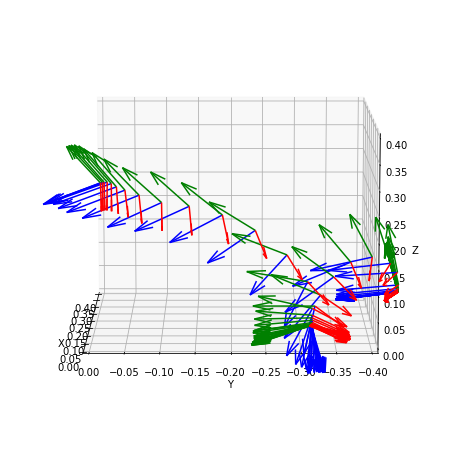

In [8]:
# Confirm our tip orientation/poses look correct in our "Standard Robot Base" coordinate frame
# https://matplotlib.org/stable/gallery/mplot3d/quiver3d.html
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
first_quat_array = clean_data[0]["quat_array"]
first_tip_pos_array = clean_data[0]["tip_pos_array"]
for i in range(0,len(first_quat_array),10):
    tip_pos = first_tip_pos_array[i]
    quat = first_quat_array[i]
    rotMat = t3d.quaternions.quat2mat(quat)
    ax.quiver(tip_pos[0],tip_pos[1],tip_pos[2], *(rotMat @ [1,0,0]), length=0.1, normalize=False, color="red")
    ax.quiver(tip_pos[0],tip_pos[1],tip_pos[2], *(rotMat @ [0,1,0]), length=0.1, normalize=False, color="green")
    ax.quiver(tip_pos[0],tip_pos[1],tip_pos[2], *(rotMat @ [0,0,1]), length=0.1, normalize=False, color="blue")
ax.view_init(elev=10, azim=180)
scale = 0.4
ax.set_xlim(0,0+scale)
ax.set_ylim(-0.4,-0.4+scale)
ax.set_zlim(0.0,0.0+scale)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

## Plot positions of a poses when near table (shows fork home and plate location)

Text(0.5, 0, 'Z')

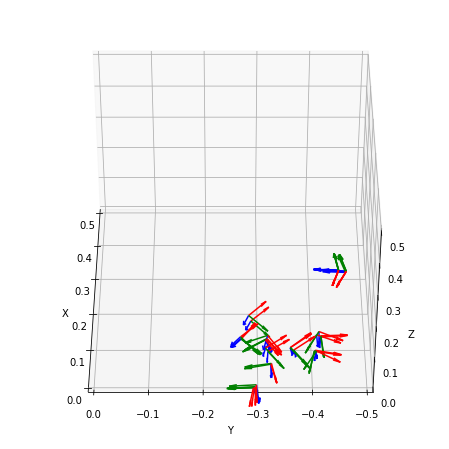

In [9]:
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
for j in range(0,100,10):
    data = clean_data[j]
    quat_array = data["quat_array"]
    pos_array = data["tip_pos_array"]
    for i in range(0,len(quat_array),50):
        quat = quat_array[i]
        tip_pos = pos_array[i]
        # ignore if fork high above table
        if tip_pos[2] > 0.03:
            continue

        rotMat = t3d.quaternions.quat2mat(quat)
        ax.quiver(tip_pos[0],tip_pos[1],tip_pos[2], *(rotMat @ [1,0,0]), length=0.05, normalize=False, color="red")
        ax.quiver(tip_pos[0],tip_pos[1],tip_pos[2], *(rotMat @ [0,1,0]), length=0.05, normalize=False, color="green")
        ax.quiver(tip_pos[0],tip_pos[1],tip_pos[2], *(rotMat @ [0,0,1]), length=0.05, normalize=False, color="blue")

ax.view_init(elev=40, azim=180)
scale = 0.5
ax.set_xlim(0,0+scale)
ax.set_ylim(-0.5,-0.5+scale)
ax.set_zlim(0.0,0.0+scale)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

## For Subject 2, fork motion from left-to-right instead of right-to-left. Clean that out.

../data/fork_trajectory_carrot/subject2_carrot/1.csv
../data/fork_trajectory_carrot/subject2_carrot/10.csv
../data/fork_trajectory_carrot/subject2_carrot/11.csv
../data/fork_trajectory_carrot/subject2_carrot/12.csv
../data/fork_trajectory_carrot/subject2_carrot/13.csv
../data/fork_trajectory_carrot/subject2_carrot/14.csv
../data/fork_trajectory_carrot/subject2_carrot/15.csv
../data/fork_trajectory_carrot/subject2_carrot/16.csv
../data/fork_trajectory_carrot/subject2_carrot/17.csv
../data/fork_trajectory_carrot/subject2_carrot/18.csv
../data/fork_trajectory_carrot/subject2_carrot/19.csv
../data/fork_trajectory_carrot/subject2_carrot/2.csv
../data/fork_trajectory_carrot/subject2_carrot/20.csv
../data/fork_trajectory_carrot/subject2_carrot/3.csv
../data/fork_trajectory_carrot/subject2_carrot/4.csv
../data/fork_trajectory_carrot/subject2_carrot/5.csv
../data/fork_trajectory_carrot/subject2_carrot/6.csv
../data/fork_trajectory_carrot/subject2_carrot/7.csv
../data/fork_trajectory_carrot/subj

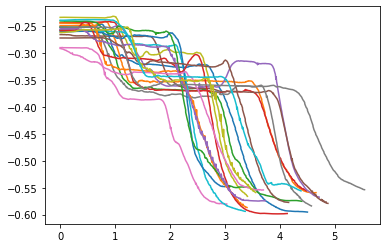

In [10]:
num = 0
for d in clean_data:
    if d["tip_pos_array"][-1,1] > -0.5:
        continue
    num+= 1
    print(d["filename"])
    plt.plot(d["time_array"], d["tip_pos_array"][:,1])
print(num)

216


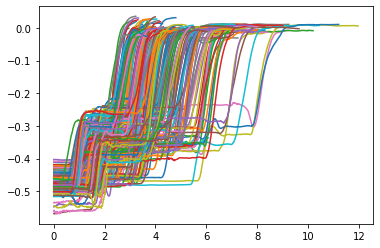

In [11]:
num = 0
for d in clean_data:
    if d["tip_pos_array"][-1,1] < -0.5:
        continue
    num+= 1
    plt.plot(d["time_array"], d["tip_pos_array"][:,1])
print(num)

### Clean to just left-to-right data (and plot to confirm)

216


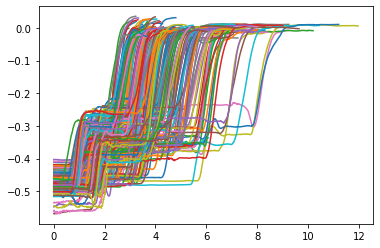

In [12]:
right_handed_data = [cd for cd in clean_data if cd["tip_pos_array"][-1,1]>-0.5]
print(len(right_handed_data))
for d in right_handed_data:
    #print(d["filename"])
    plt.plot(d["time_array"], d["tip_pos_array"][:,1])

216


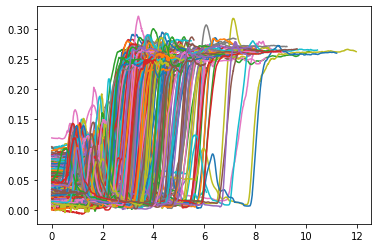

In [13]:
right_handed_data = [cd for cd in clean_data if cd["tip_pos_array"][-1,1]>-0.5]
print(len(right_handed_data))
for d in right_handed_data:
    #print(d["filename"])
    plt.plot(d["time_array"], d["tip_pos_array"][:,2])

# Segment Trajectory

In [14]:
labeled_segments = segment_trajectory(right_handed_data, up_hysterisis, down_hysterisis, debug=False)

0.0030443070637996062
0.0030443070637996062


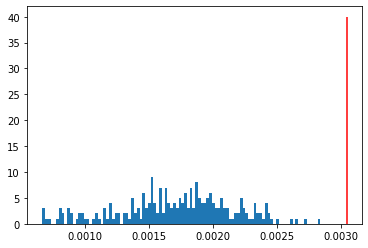

In [15]:
# repeatedly remove any outlier trajectory segments with velocity 
# variance greater than 3 std away from inliers until convergence
std_vel_array = []
for ls in labeled_segments:
    si = ls["start_index"]
    ei = ls["end_index"]
    vel_array = ls["tip_pos_array"][si:ei][1:,2] - ls["tip_pos_array"][si:ei][:-1,2]
    std_vel_array.append(np.std(vel_array))
std_vel_array = np.array(std_vel_array)
plt.hist(std_vel_array, bins=100);
prev_outlier_cutoff = None
outlier_cutoff = np.Inf
while outlier_cutoff != prev_outlier_cutoff:
    prev_outlier_cutoff = outlier_cutoff
    inlier_indxs = std_vel_array < outlier_cutoff
    outlier_cutoff = np.mean(std_vel_array[inlier_indxs]) + np.std(std_vel_array[inlier_indxs]) * 3
    print(outlier_cutoff)
    prev_inlier_count = inlier_indxs
plt.vlines(outlier_cutoff, 0, 40, colors="red")

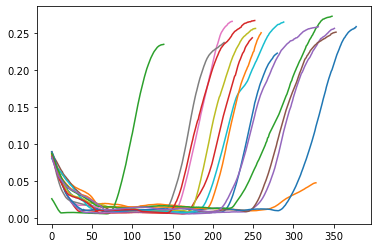

In [16]:
for i, ls in enumerate(labeled_segments[:15]):
    si = ls["start_index"]
    ei = ls["end_index"]
    vel_array = ls["tip_pos_array"][si:ei][1:,2] - ls["tip_pos_array"][si:ei][:-1,2]
    # plot the especially noisy data
    if np.std(vel_array) < outlier_cutoff:
        plt.plot(ls["tip_pos_array"][si:ei][:,2])

In [17]:
for i, ls in enumerate(labeled_segments):
    si = ls["start_index"]
    ei = ls["end_index"]
    vel_array = ls["tip_pos_array"][si:ei][1:,2] - ls["tip_pos_array"][si:ei][:-1,2]
    # plot the especially noisy data
    if np.std(vel_array) > outlier_cutoff:
        plt.plot(ls["tip_pos_array"][si:ei][:,2])

In [18]:
not_reaquisition_data_array = []
for i, ls in enumerate(labeled_segments):
    si = ls["start_index"]
    ei = ls["end_index"]
    vel_array = ls["tip_pos_array"][si:ei][1:,2] - ls["tip_pos_array"][si:ei][:-1,2]
    # remove the especially noisy data
    #if np.std(vel_array) > outlier_cutoff:
        #print("velocity array too noisy", ls["filename"])
    #    continue
    # remove any data that starts too close to the plate
    if np.min(ls["tip_pos_array"][si:ei][1,2]) < 0.05:
        print("starts too low (likely a re-acquisition attempt)", ls["filename"])
        continue
    not_reaquisition_data_array.append(ls)

starts too low (likely a re-acquisition attempt) ../data/fork_trajectory_carrot/subject10_carrot/10.csv
starts too low (likely a re-acquisition attempt) ../data/fork_trajectory_carrot/subject11_carrot/10.csv
starts too low (likely a re-acquisition attempt) ../data/fork_trajectory_carrot/subject12_carrot/1.csv
starts too low (likely a re-acquisition attempt) ../data/fork_trajectory_carrot/subject12_carrot/17.csv
starts too low (likely a re-acquisition attempt) ../data/fork_trajectory_carrot/subject12_carrot/9.csv
starts too low (likely a re-acquisition attempt) ../data/fork_trajectory_carrot/subject1_carrot/15.csv
starts too low (likely a re-acquisition attempt) ../data/fork_trajectory_carrot/subject3_carrot/16.csv
starts too low (likely a re-acquisition attempt) ../data/fork_trajectory_carrot/subject4_carrot/11.csv
starts too low (likely a re-acquisition attempt) ../data/fork_trajectory_carrot/subject4_carrot/14.csv
starts too low (likely a re-acquisition attempt) ../data/fork_trajecto

In [19]:
print(len(labeled_segments), "--->", len(not_reaquisition_data_array))

234 ---> 217


In [20]:
clean_labeled_data = []
clean_data_index = 0
for ls in not_reaquisition_data_array:
    si = ls["start_index"]
    ei = ls["end_index"]
    # remove any that would be relabeled with a smaller hysterisis value
    down_hysterisis = 0.001
    up_hysterisis = 0.001
    smaller_data = [{"tip_pos_array": ls["tip_pos_array"][si:ei],
                                     "quat_array": ls["quat_array"][si:ei],
                                     "filename": ls["filename"],
                                     "raw": ls["raw"]}]
    # remove any that would be relabeled with a smaller hysterisis value
    down_hysterisis = 0.001
    up_hysterisis = 0.001
    relabeled = segment_trajectory(smaller_data, up_hysterisis, down_hysterisis, has_picked_up_fork=True, debug=False)
    if len(relabeled) > 1:
        print("would be relabeled with smaller hysterisis value", smaller_data[0]["filename"])
        continue
    ls["clean_data_index"] = clean_data_index
    clean_data_index += 1
    clean_labeled_data.append(ls)

would be relabeled with smaller hysterisis value ../data/fork_trajectory_carrot/subject10_carrot/10.csv
would be relabeled with smaller hysterisis value ../data/fork_trajectory_carrot/subject10_carrot/11.csv
would be relabeled with smaller hysterisis value ../data/fork_trajectory_carrot/subject10_carrot/12.csv
would be relabeled with smaller hysterisis value ../data/fork_trajectory_carrot/subject10_carrot/13.csv
would be relabeled with smaller hysterisis value ../data/fork_trajectory_carrot/subject10_carrot/14.csv
would be relabeled with smaller hysterisis value ../data/fork_trajectory_carrot/subject10_carrot/15.csv
would be relabeled with smaller hysterisis value ../data/fork_trajectory_carrot/subject10_carrot/16.csv
would be relabeled with smaller hysterisis value ../data/fork_trajectory_carrot/subject10_carrot/2.csv
would be relabeled with smaller hysterisis value ../data/fork_trajectory_carrot/subject10_carrot/3.csv
would be relabeled with smaller hysterisis value ../data/fork_traj

In [21]:
print(len(not_reaquisition_data_array), "--->", len(clean_labeled_data))

217 ---> 133


# Calculate Impact Index (highest z force)

In [22]:
impact_labeled_data = []
for ls in clean_labeled_data:
    index_list = np.arange(len(ls["raw"]['F_zN']))
    si = ls["start_index"]
    ei = ls["end_index"]
    within_index = np.logical_and(index_list < ei, index_list >= si)
    ls["impact_index"] = np.argmax(ls["raw"]['F_zN'] * within_index)
    #plt.plot(ls["raw"]['F_zN'])
    #plt.plot(within_index)
    #plt.show();plt.close();
    impact_labeled_data.append(ls)

In [23]:
print(f"We currently have {len(impact_labeled_data)} samples")

We currently have 133 samples


# Use force sensor to detect making contact with food and breaking contact with table. Truncate trajectories based on this information.

In [24]:
minimum_border = 20
for d in impact_labeled_data:
    start_tscores = []
    end_tscores = []
    si = d["start_index"]
    ei = d["end_index"]
    start_touch_ind = None
    end_touch_ind = None
    for testi in range(si+minimum_border,ei-1):
        model_dat = d["raw"]["F_zN"][si:testi]
        model_ts = np.array(d["raw"]["Times"][si:testi])
        test_dat = d["raw"]["F_zN"][testi+1]
        test_ts = np.array(d["raw"]["Times"][testi+1])
        # multiply by zero to use constant model for these
        tscore = get_t_value_of_linear_model(model_ts,model_dat, test_ts, test_dat,constant_model=True)
        start_tscores.append(tscore)
        if start_touch_ind is None and tscore > 0.5:
            start_touch_ind = testi + 1
    for testi in range(ei-minimum_border,si+1,-1):
        model_dat = d["raw"]["F_zN"][testi:ei]
        model_ts = d["raw"]["Times"][testi:ei]
        test_dat = d["raw"]["F_zN"][testi-1]
        test_ts = d["raw"]["Times"][testi-1]
        tscore = get_t_value_of_linear_model(model_ts,model_dat, test_ts, test_dat)
        end_tscores.append(tscore)
        if end_touch_ind is None and tscore > 1:
            end_touch_ind = testi - 1
    d["start_touch_index"] = start_touch_ind
    d["end_touch_index"] = end_touch_ind
    d["start_tscores"] = np.array(start_tscores)
    d["end_tscores"] = np.array(end_tscores[::-1])

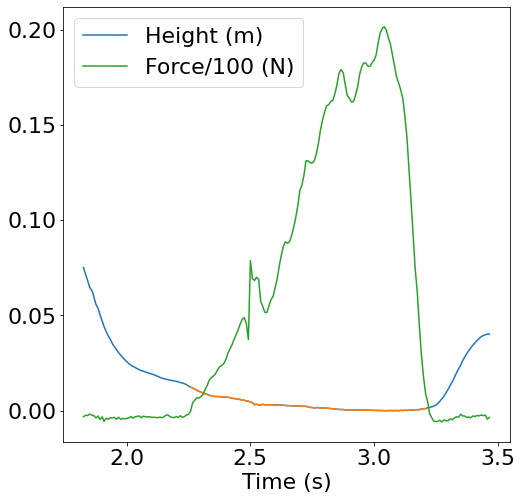

In [25]:
font = {'size'   : 22}
matplotlib.rc('font', **font)
f = plt.figure(figsize=(8,8))
dat = impact_labeled_data[1]
sti = dat["start_touch_index"]
eti = dat["end_touch_index"]
si = dat["start_index"]
ei = dat["end_index"]
tableh = np.min(dat["tip_pos_array"][:,2])
plt.plot(dat["raw"]["Times"][np.arange(si,ei)],dat["tip_pos_array"][si:ei,2]-tableh,label= "Height (m)")
plt.plot(dat["raw"]["Times"][np.arange(sti,eti)],dat["tip_pos_array"][sti:eti,2]-tableh)
plt.plot(dat["raw"]["Times"][np.arange(si,ei)],dat["raw"]["F_zN"][si:ei]/100,label="Force/100 (N)")
plt.xlabel("Time (s)")
plt.legend()
f.savefig(f"TrajectoryTruncationExample{foodname}.png")

## Remove trajectories where impact is not detected (for at least 10 timesteps) and truncate trajectories to go no higher than 1cm above food contact before and 4cm above table departure after

133 ---> 131
We now have 131 samples


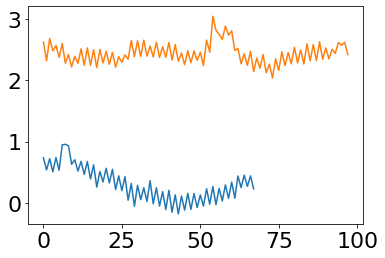

In [26]:
trunc_clean_labeled_data = []
for d in impact_labeled_data:
    index_list = np.arange(len(d["raw"]['Times']))
    si = d["start_index"]
    ei = d["end_index"]
    #print(si,ei)
    within_index = np.logical_and(index_list < ei, index_list >= si)
    sti = d["start_touch_index"]
    eti = d["end_touch_index"]
    if (eti is None or sti is None or
            eti - sti < 10):
        #print("do we really need to remove", d["filename"], " or is ", ei-si, "small?")
        plt.plot(d["raw"]["F_zN"][si:ei])
        continue
    #low_inds = (d["tip_pos_array"][:,2]-d["tip_pos_array"][sti,2]) < max_height_above_contact
    #low_end_inds = (d["tip_pos_array"][:,2]-d["tip_pos_array"][eti,2]) < max_height_after_plate
    
    # Trajectory starts at max_height_above_contact above contact
    low_inds = (d["tip_pos_array"][:,2]-d["tip_pos_array"][sti,2]) < max_height_above_contact
    # trajectory ends at final max_height_after_plate (we don't use eti, since eti is basically
    #    just when the fork leaves the table, and this is easier to explain)
    low_end_inds = (d["tip_pos_array"][:,2]-np.min(d["tip_pos_array"][:,2])) < max_height_after_plate
    start_inx = np.min(np.nonzero(low_inds * within_index))
    end_inx = np.max(np.nonzero(low_end_inds * within_index))
    trunc_clean_labeled_data.append({
                             "tip_pos_array": d["tip_pos_array"],
                             "quat_array": d["quat_array"],
                             "attempt_array": d["attempt_array"],
                             "filename": d["filename"],
                             "start_touch_index": d["start_touch_index"],
                             "end_touch_index": d["end_touch_index"],
                             "raw":d["raw"],
                             "start_index":start_inx,
                             "end_index":end_inx,
                             "impact_index": d["impact_index"]})
#trunc_clean_labeled_data = [ild for ild in impact_labeled_data if ild["end_index"] - ild["start_index"] > 50]
print(len(impact_labeled_data), "--->", len(trunc_clean_labeled_data))
print(f"We now have {len(trunc_clean_labeled_data)} samples")



In [27]:
scaled_start_times = []
scaled_stop_times = []
for d in trunc_clean_labeled_data:
    si = d["start_index"]
    ei = d["end_index"]
    ts = d["raw"]["Times"][si:ei]
    curmin = np.min(d["tip_pos_array"][si:ei][:,2])
    #plt.plot((ts-ts[0])/(ts[-1]-ts[0]), d["raw"]["F_zN"][si:ei])
    it = ((d["raw"]["Times"][d["impact_index"]]-ts[0])/
             (ts[-1]-ts[0]))
    st = ((d["raw"]["Times"][d["start_index"]]-ts[0])/
             (ts[-1]-ts[0]))
    et = ((d["raw"]["Times"][d["end_index"]]-ts[0])/
             (ts[-1]-ts[0]))
    #plt.plot((ts-ts[0])/(ts[-1]-ts[0]), d["tip_pos_array"][si:ei,2])
    #plt.scatter(it,d["tip_pos_array"][d["impact_index"],2],c="red")
    #plt.scatter(st,d["tip_pos_array"][d["start_touch_index"],2],c="blue")
    #plt.scatter(et,d["tip_pos_array"][d["end_touch_index"],2],c="blue")
    scaled_start_times.append(st)
    scaled_stop_times.append(et)
    #plt.show();plt.close()
scaled_start_times=np.array(scaled_start_times)
scaled_stop_times=np.array(scaled_stop_times)

In [28]:
print(np.mean(scaled_start_times),np.mean(scaled_stop_times))
# so, let's do, say, 0-20-70-100

0.0 1.0080178986904584


# Ignore trajectories with outliers in initial orientation

## Plot all orientations over all time

In [29]:
font = {'size'   : 22}
matplotlib.rc('font', **font)

## Remove trajectories containing outlier orientations

In [31]:
prev_exceptions = [-1]
exceptional_rotations = []
while np.all(prev_exceptions!=exceptional_rotations):
    prev_exceptions = exceptional_rotations
    all_quats = np.empty(shape=(0,5))
    exceptional_rotations = []
    for dat_index, d in enumerate(trunc_clean_labeled_data):
        quats = d["quat_array"][d["start_index"]:(d["end_index"])]
        if np.any(np.einsum("ij,jk,ik->i",quats[:,:4]-meanquat, np.linalg.inv(covmat), quats[:,:4]-meanquat) > 25):
            print(dat_index)
            exceptional_rotations.append(dat_index)
        else:    
            ts = np.linspace(0,1,len(quats)).reshape(-1,1)
            all_quats = np.vstack((all_quats,np.hstack((quats,ts))))
    covmat = np.cov(all_quats[:,:4].T)
    meanquat = np.mean(all_quats[:,:4],axis=0)
    print(meanquat)

4
30
31
36
46
50
59
83
84
85
114
118
122
[-0.04905979  0.39126473 -0.86456356  0.05479497]
4
26
30
31
35
36
46
50
59
73
82
83
84
85
87
93
101
114
118
120
122
130
[-0.04454965  0.3828973  -0.88011952  0.05695967]
2
4
26
30
31
33
35
36
46
48
50
59
73
82
83
84
85
87
93
101
114
118
120
122
126
129
130
[-0.04223344  0.37571287 -0.89016339  0.05773681]
2
4
26
30
31
33
35
36
38
46
48
50
59
73
82
83
84
85
87
89
93
101
114
115
118
120
122
126
127
129
130
[-0.04261211  0.3731055  -0.89264532  0.05860223]
2
4
26
30
31
33
35
36
38
45
46
48
50
59
72
73
82
83
84
85
87
89
93
101
114
115
118
119
120
122
126
127
129
130
[-0.04151229  0.37116251 -0.89441694  0.05767645]
2
4
26
30
31
33
34
35
36
38
45
46
48
50
59
71
72
73
82
83
84
85
87
89
93
101
114
115
118
119
120
122
126
127
128
129
130
[-0.03654063  0.35589908 -0.90570818  0.05619808]
2
4
26
30
31
33
34
35
36
38
44
45
46
48
50
59
71
72
73
82
83
84
85
87
89
93
101
114
115
118
119
120
122
126
127
128
129
130
[-0.03686686  0.35710343 -0.90499632  0.0574

## Plot Orienatations of Inlier Trajectories

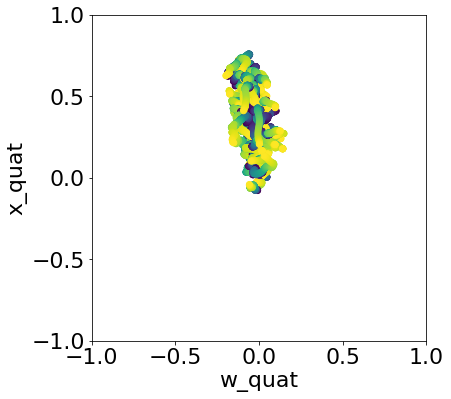

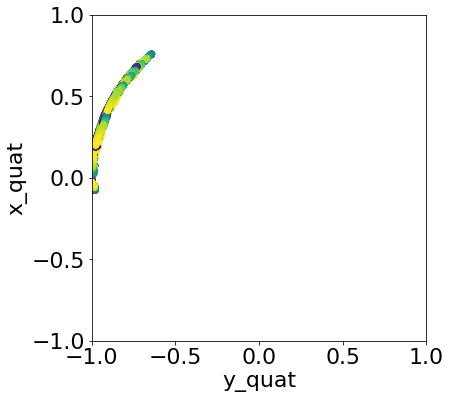

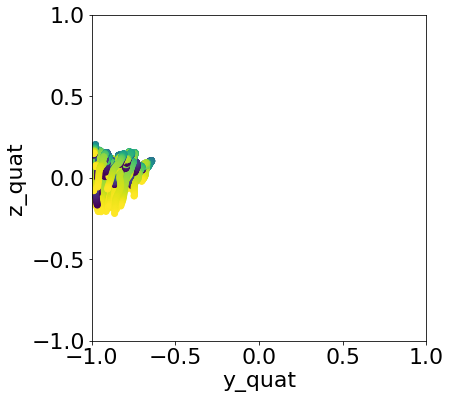

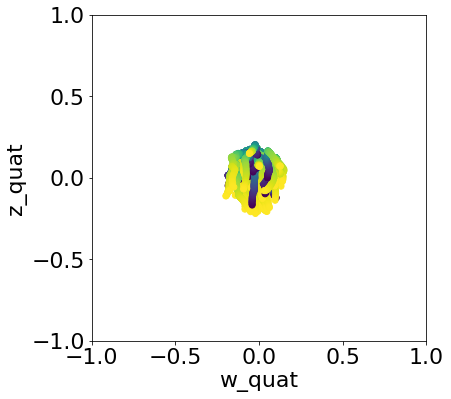

In [32]:
f = plt.figure(figsize=(6,6))
plt.scatter(all_quats[:,0],all_quats[:,1], c=all_quats[:,4])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("w_quat")
plt.ylabel("x_quat")
plt.show();
#f.savefig(f"{labmtgdir}/{foodname}_very_clean_raw_wx_orientations.png",bbox_inches="tight")
plt.close();
f = plt.figure(figsize=(6,6))
plt.scatter(all_quats[:,2],all_quats[:,1], c=all_quats[:,4])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("y_quat")
plt.ylabel("x_quat")
plt.show();
#f.savefig(f"{labmtgdir}/{foodname}_very_clean_raw_yx_orientations.png",bbox_inches="tight")
plt.close();
f = plt.figure(figsize=(6,6))
plt.scatter(all_quats[:,2],all_quats[:,3], c=all_quats[:,4])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("y_quat")
plt.ylabel("z_quat")
#f.savefig(f"{labmtgdir}/{foodname}_very_clean_raw_yz_orientations.png",bbox_inches="tight")
plt.show();plt.close();
f = plt.figure(figsize=(6,6))
plt.scatter(all_quats[:,0],all_quats[:,3], c=all_quats[:,4])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("w_quat")
plt.ylabel("z_quat")
#f.savefig(f"{labmtgdir}/{foodname}_very_clean_raw_wz_orientations.png",bbox_inches="tight")
plt.show();plt.close();

# Summarize Trajectory Generation

In [33]:
print("Number of data files:")
print(len(clean_data))
print("Remove left-to-right files:")
print(len(clean_data), "--->", len(right_handed_data))
print("Identify down-up segments (with some hysteresis):")
print(len(right_handed_data), "--->", len(labeled_segments))
print("starts too low (likely a re-acquisition attempt):")
print(len(labeled_segments), "--->", len(not_reaquisition_data_array))
print("remove segments that would be relabeled with smaller hysteresis value (complicated reprod to pickup)")
print(len(not_reaquisition_data_array), "--->", len(clean_labeled_data))
print("remove any where a linear model can't detect food impact using force measurer")
print(len(impact_labeled_data), "--->", len(trunc_clean_labeled_data))
print("remove any outliers in orientation space (underrepresented fork strategies)")
print(len(trunc_clean_labeled_data), "--->", len(trunc_clean_labeled_data)-len(exceptional_rotations))

Number of data files:
236
Remove left-to-right files:
236 ---> 216
Identify down-up segments (with some hysteresis):
216 ---> 234
starts too low (likely a re-acquisition attempt):
234 ---> 217
remove segments that would be relabeled with smaller hysteresis value (complicated reprod to pickup)
217 ---> 133
remove any where a linear model can't detect food impact using force measurer
133 ---> 131
remove any outliers in orientation space (underrepresented fork strategies)
131 ---> 93


# Save trajectories

In [34]:
num_time_samples = 64

In [35]:
savefilename = f"{foodname}_clean_pickups"

In [36]:
import os
import shutil
shutil.rmtree(savefilename,ignore_errors=True)
os.makedirs(savefilename, exist_ok=True)
dat_index = 0
for old_dat_index, d in enumerate(trunc_clean_labeled_data):
    # skip the trajectories with exceptional_rotations
    if old_dat_index in exceptional_rotations:
        continue
    ts = d["raw"]["Times"]
    data_array = np.concatenate((((ts - ts[d["start_index"]])/(ts[d["end_index"]] - ts[d["start_index"]])).reshape(-1,1),d["tip_pos_array"],d["quat_array"]),axis=1)
    data,_ = linear_sample_trajectory(data_array, ts, d["start_index"], d["end_index"],num_time_samples)
    origin_inx = np.argmin(data[:,3])
    origin = data[origin_inx,:]
    data[:,1:4] = data[:,1:4] - origin[1:4]
    np.save(f"{savefilename}/pickup_attempt{dat_index}",data[:,1:])
    with open(f"{savefilename}/pickup_attempt{dat_index}_info.csv","w") as f:
        f.write(f"{savefilename}/pickup_attempt{dat_index},{d['filename']},{d['start_index']},{d['impact_index']},{d['end_index']}")
    print(dat_index, d["filename"])
    dat_index += 1

0 ../data/fork_trajectory_carrot/subject10_carrot/1.csv
1 ../data/fork_trajectory_carrot/subject11_carrot/10.csv
2 ../data/fork_trajectory_carrot/subject11_carrot/12.csv
3 ../data/fork_trajectory_carrot/subject11_carrot/15.csv
4 ../data/fork_trajectory_carrot/subject11_carrot/16.csv
5 ../data/fork_trajectory_carrot/subject11_carrot/18.csv
6 ../data/fork_trajectory_carrot/subject11_carrot/19.csv
7 ../data/fork_trajectory_carrot/subject11_carrot/2.csv
8 ../data/fork_trajectory_carrot/subject11_carrot/20.csv
9 ../data/fork_trajectory_carrot/subject11_carrot/3.csv
10 ../data/fork_trajectory_carrot/subject11_carrot/4.csv
11 ../data/fork_trajectory_carrot/subject11_carrot/5.csv
12 ../data/fork_trajectory_carrot/subject11_carrot/6.csv
13 ../data/fork_trajectory_carrot/subject11_carrot/7.csv
14 ../data/fork_trajectory_carrot/subject11_carrot/8.csv
15 ../data/fork_trajectory_carrot/subject11_carrot/9.csv
16 ../data/fork_trajectory_carrot/subject12_carrot/11.csv
17 ../data/fork_trajectory_carrot

In [37]:
num_total_trajectories = dat_index

In [38]:
print(num_total_trajectories)

93


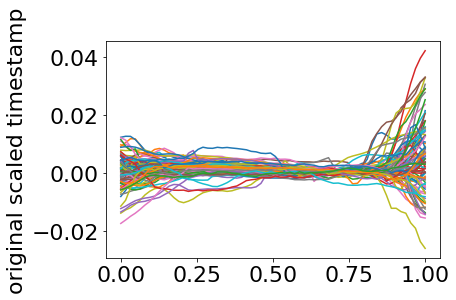

In [39]:
for dat_index in range(num_total_trajectories):
    ddd = np.load(f"{savefilename}/pickup_attempt{dat_index}.npy")
    plt.plot(np.linspace(0,1,len(ddd[:,0])),ddd[:,0])
plt.ylabel("original scaled timestamp")
plt.show();plt.close();

In [40]:
print(f"We now have {num_total_trajectories} trajectories")

We now have 93 trajectories


# Review Saved Trajectories

Text(0.5, 0, 'new scaled time')

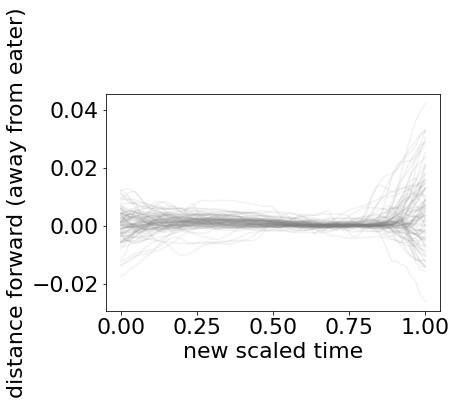

In [41]:
for attempt in range(num_total_trajectories):#(134):
    #print(attempt)[:,4]
    d = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
    plt.plot(np.linspace(0,1,num_time_samples), d[:,0],c="gray",alpha=0.1)
plt.ylabel("distance forward (away from eater)")
plt.xlabel("new scaled time")

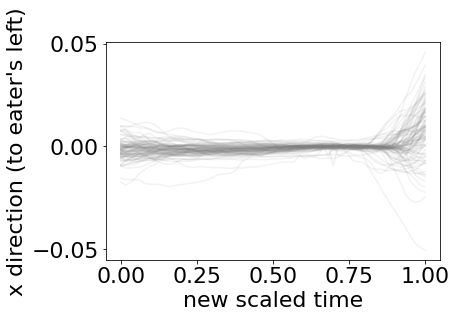

In [42]:
for attempt in range(num_total_trajectories):#(134):
    #print(attempt)
    d = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
    plt.plot(np.linspace(0,1,num_time_samples), d[:,1],c="gray",alpha=0.1)
plt.ylabel("x direction (to eater's left)")
plt.xlabel("new scaled time");

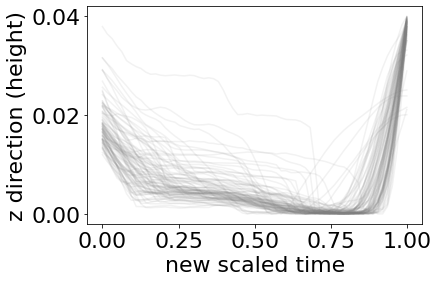

In [43]:
for attempt in range(num_total_trajectories):#(134):
    #print(attempt)
    d = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
    plt.plot(np.linspace(0,1,num_time_samples), d[:,2],c="gray",alpha=0.1)
    
plt.ylabel("z direction (height)")
plt.xlabel("new scaled time");

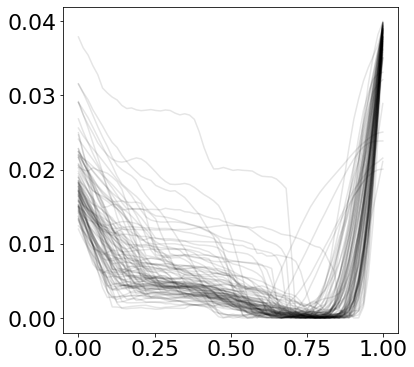

In [44]:
f = plt.figure(figsize=(6,6))
for attempt in range(num_total_trajectories):#(134):
    d = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
    plt.plot(np.linspace(0,1,num_time_samples), d[:,2],c="k",alpha=0.1)
f.savefig(f"{foodname}HeightOverScaledTime.jpeg")

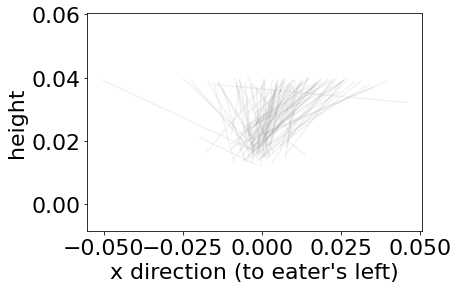

In [45]:
for attempt in range(num_total_trajectories):#(134):
    #print(attempt)
    d = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
    plt.plot(d[(0,num_time_samples-1),1], (d[(0,num_time_samples-1),2]),c="gray",alpha=0.1)
    plt.axis("equal")
    plt.ylabel("height")
    plt.xlabel("x direction (to eater's left)")

# check filenames

In [46]:
for old_dat_index, d in enumerate(trunc_clean_labeled_data):
    # skip the trajectories with exceptional_rotations
    if old_dat_index in exceptional_rotations:
        continue
    print(d["filename"])

../data/fork_trajectory_carrot/subject10_carrot/1.csv
../data/fork_trajectory_carrot/subject11_carrot/10.csv
../data/fork_trajectory_carrot/subject11_carrot/12.csv
../data/fork_trajectory_carrot/subject11_carrot/15.csv
../data/fork_trajectory_carrot/subject11_carrot/16.csv
../data/fork_trajectory_carrot/subject11_carrot/18.csv
../data/fork_trajectory_carrot/subject11_carrot/19.csv
../data/fork_trajectory_carrot/subject11_carrot/2.csv
../data/fork_trajectory_carrot/subject11_carrot/20.csv
../data/fork_trajectory_carrot/subject11_carrot/3.csv
../data/fork_trajectory_carrot/subject11_carrot/4.csv
../data/fork_trajectory_carrot/subject11_carrot/5.csv
../data/fork_trajectory_carrot/subject11_carrot/6.csv
../data/fork_trajectory_carrot/subject11_carrot/7.csv
../data/fork_trajectory_carrot/subject11_carrot/8.csv
../data/fork_trajectory_carrot/subject11_carrot/9.csv
../data/fork_trajectory_carrot/subject12_carrot/11.csv
../data/fork_trajectory_carrot/subject12_carrot/13.csv
../data/fork_trajec